In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [76]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [77]:
tf.__version__

'1.7.0'

In [78]:
session = tf.Session()

## Example 1: linear regression

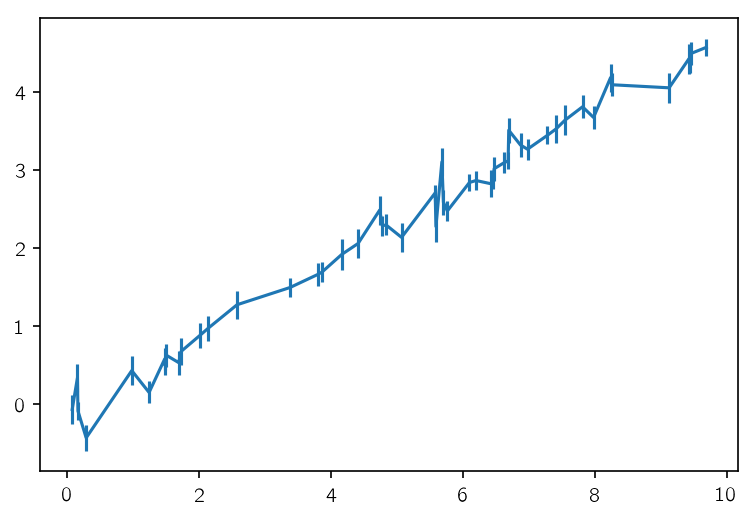

In [79]:
x = np.sort(np.random.uniform(0, 10, 50))
yerr = np.random.uniform(0.1, 0.2, len(x))
y = 0.5 * x - 0.2 + yerr * np.random.randn(len(x))

plt.errorbar(x, y, yerr=yerr);

In [80]:
import numpy as np

ivar = 1.0 / yerr**2
A = np.vander(x, 2)
ATA = np.dot(A.T, A*ivar[:, None])
ATy = np.dot(A.T, y*ivar)
w = np.linalg.solve(ATA, ATy)
print(w)

[ 0.49415594 -0.16672479]


In [81]:
import tensorflow as tf

ivar = tf.constant(1.0 / yerr**2)
A = tf.constant(np.vander(x, 2))
ATA = tf.matmul(A, A*ivar[:, None], transpose_a=True)
ATy = tf.matmul(A, (y*ivar)[:, None], transpose_a=True)
w = tf.linalg.solve(ATA, ATy)
print(tf.Session().run(w))

[[ 0.49415594]
 [-0.16672479]]


In [82]:
print(w)

Tensor("MatrixSolve_1:0", shape=(2, 1), dtype=float64)


In [83]:
m = tf.Variable(0.5, dtype=tf.float64)
b = tf.Variable(-0.2, dtype=tf.float64)
log_s = tf.Variable(np.log(0.2), dtype=tf.float64)
s = tf.exp(log_s)

model = m * x + b
log_like = -0.5 * tf.reduce_sum(((y - model) / s) ** 2)
log_like -= 0.5 * len(x) * tf.log(2*np.pi*s**2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(log_like))
    print(sess.run(tf.gradients(log_like, [m, b, log_s])))

15.35219850605484
[18.65326432879411, 18.33662402360158, -11.65445908916692]


In [84]:
from tensorflow.contrib.opt import ScipyOptimizerInterface

In [85]:
var_list = [m, b, log_s]
opt = ScipyOptimizerInterface(-log_like, var_list)

In [86]:
session.run(tf.global_variables_initializer())
opt.minimize(session)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -16.702095
  Number of iterations: 16
  Number of functions evaluations: 19


In [87]:
session.run(var_list)

[0.492485808174112, -0.1474652369889333, -1.7529804556009296]

In [88]:
import simple_hmc

In [89]:
metric = simple_hmc.DiagonalMetric(3, 1./np.abs(session.run(tf.hessians(log_like, var_list))))

In [90]:
strt = time.time()
results = simple_hmc.tf_simple_nuts(session, log_like, var_list, 10000, 0.5, metric)
nuts_time = time.time() - strt

100%|██████████| 10000/10000 [01:19<00:00, 126.50it/s]


In [91]:
nuts_time

79.25024104118347

In [92]:
results[-1]

0.7740615328749137

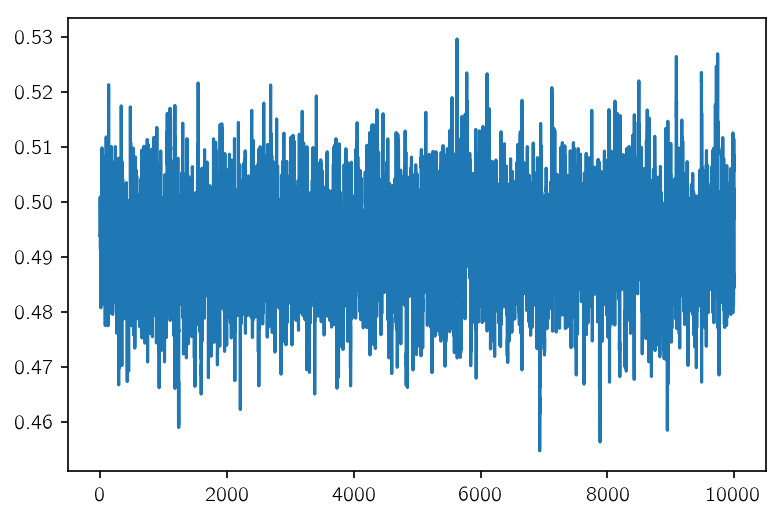

In [93]:
plt.plot(results[0][:, 0])

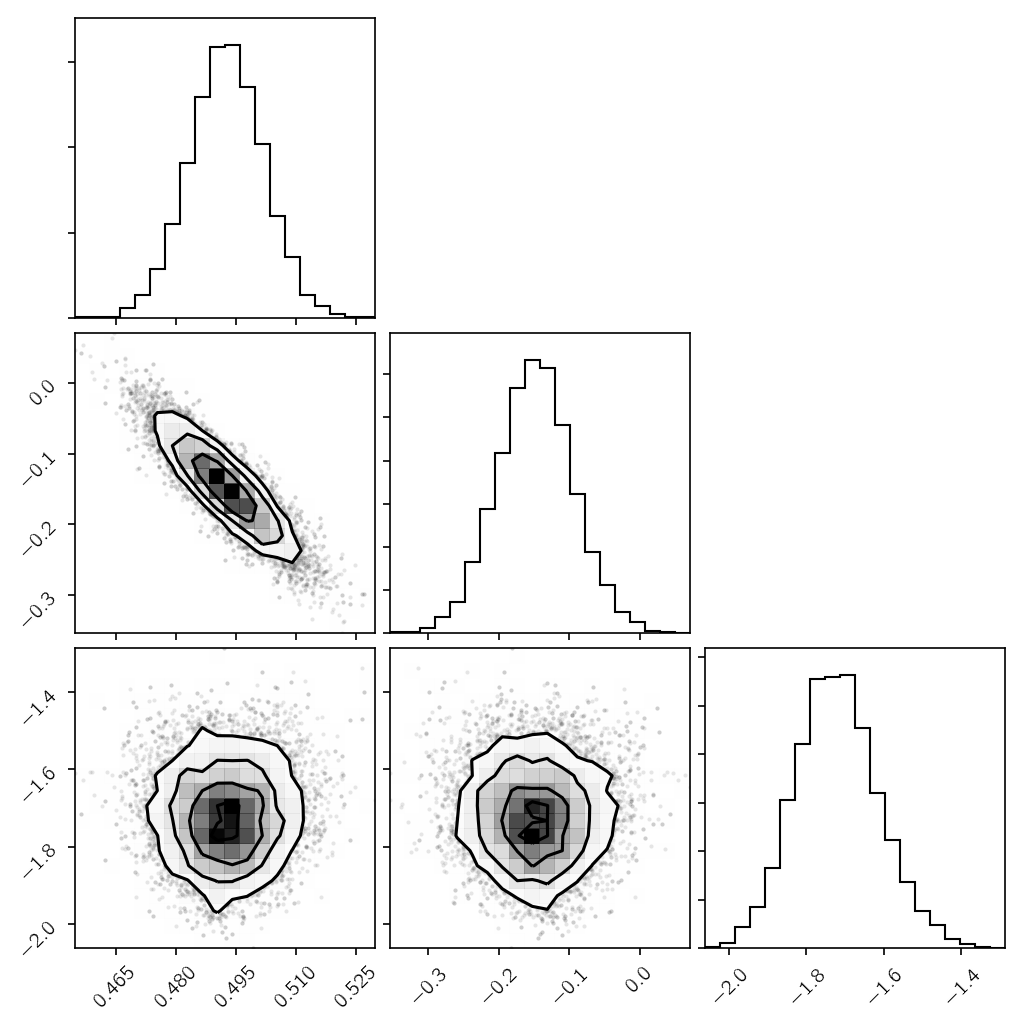

In [94]:
import corner
corner.corner(results[0]);

In [95]:
import emcee
initial_vars = session.run(var_list)
sizes = [np.size(v) for v in initial_vars]
shapes = [np.shape(v) for v in initial_vars]
q = np.concatenate([np.reshape(v, s) for v, s in zip(initial_vars, sizes)])

def get_feed_dict(vector):
    i = 0
    fd = dict()
    for var, size, shape in zip(var_list, sizes, shapes):
        fd[var] = np.reshape(vector[i:i+size], shape)
        i += size
    return fd

def log_prob(params):
    fd = get_feed_dict(params)
    return session.run(log_like, feed_dict=fd)

initial = results[0][np.random.randint(len(results[0]), size=32)]
nwalkers, ndim = initial.shape

strt = time.time()
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
pos, _, _ = sampler.run_mcmc(initial, 500);
sampler.reset()
pos, _, _ = sampler.run_mcmc(initial, 2000);
emcee_time = time.time() - strt

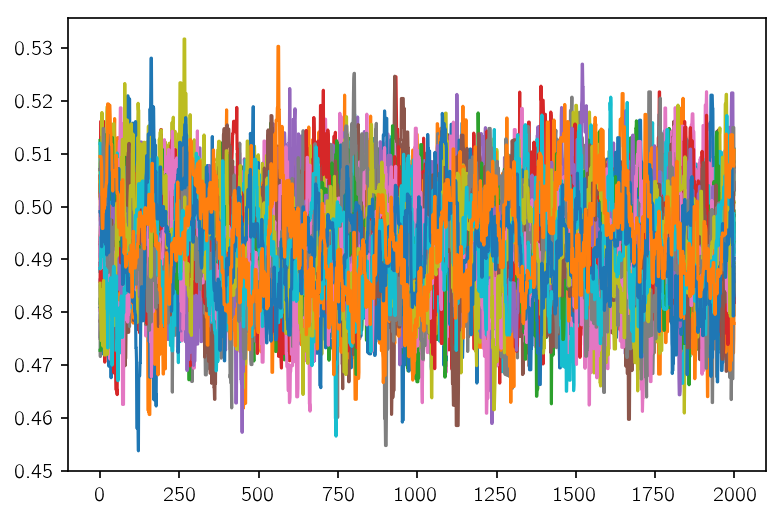

In [96]:
plt.plot(sampler.chain[:, :, 0].T);

In [97]:
samples = sampler.flatchain

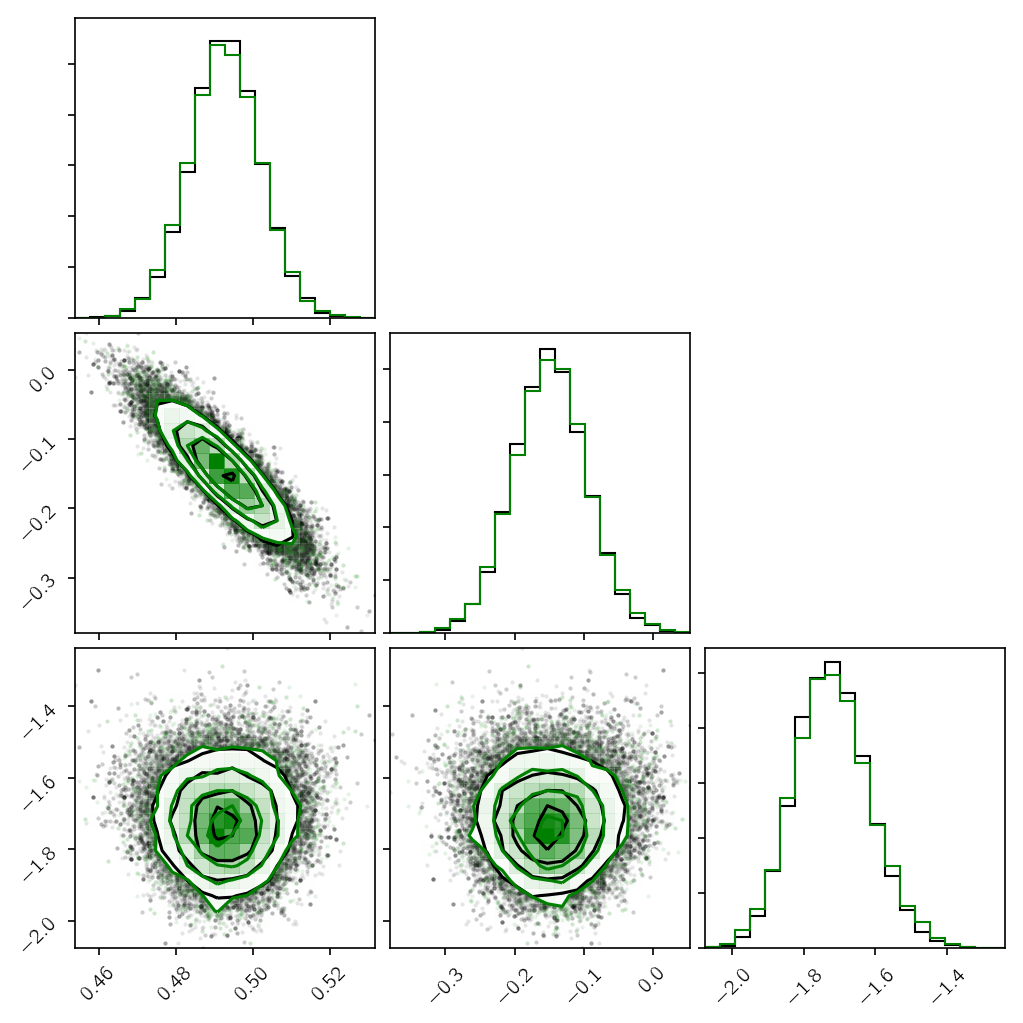

In [98]:
ranges = [(s.min(), s.max()) for s in samples.T]
fig = corner.corner(samples, range=ranges);
corner.corner(results[0], range=ranges, fig=fig, color="g", weights=len(samples) * np.ones(len(results[0])) / len(results[0]));

In [101]:
n_ind_emcee = len(samples) / np.max(sampler.get_autocorr_time())
n_ind_nuts = len(results[0]) / np.max([emcee.autocorr.integrated_time(results[0][:, i])[0] for i in range(3)])

print("emcee: \nN_ind = {0:.0f}\n{1:.5f} seconds/independent sample".format(n_ind_emcee, emcee_time / n_ind_emcee))
print("nuts:  \nN_ind = {0:.0f}\n{1:.5f} seconds/independent sample".format(n_ind_nuts, nuts_time / n_ind_nuts))

emcee: 
N_ind = 1884
0.01105 seconds/independent sample
nuts:  
N_ind = 1572
0.05040 seconds/independent sample
